In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# SAMS 
## Run 1

In [2]:
from pymbar import bar, timeseries


def log_density_factor(nwats, initial, final):
    """
    The proposal probability for selecting two water molecules to swap with an anion and cation. 
    """
    if initial < final:
        return np.log(1.0 * nwats * (nwats - 1) / (initial + 1) / (initial + 1))
    else:
        return np.log(1.0 * initial * initial / (nwats + 1) / (nwats + 2))

    
def calc_bar(initial, final, nwats, proposals, work):
    """
    Calculate free energies from protocol work to insert or delete salt. 
    
    Parameters
    ----------
    initial: int
        the initial number of salt pairs, from which you want to calculate the free energy from.
    final: int
        the final number of salt pairs, from which you want to calculate the free energy to.
    nwats: numpy.ndarray
        array containing the number of water molecules for each iteration.
    proposals: numpy.ndarray
        array of the proposed moves, e.g. proposals[10] = np.array([4, 5]).
    work: numpy.ndarray
        array of protocol work for each proposal in kT.
        
    Returns
    -------
    estimate: float
        estimate of the free energy in kT.
    error: float
        estimated standard deviation on estimate in kT.
    """
    work_add = []
    work_remove = []
        
    for i in range(len(proposals)):
        if np.all(proposals[i] == np.array([initial, final])):
            work_add.append(work[i] - log_density_factor(nwats[i], initial, final))
        elif np.all(proposals[i] == np.array([final, initial])):
            work_remove.append(work[i] - log_density_factor(nwats[i], initial, final))

    work_add = np.array(work_add)
    work_remove = np.array(work_remove)    
    return bar.BAR(work_add, work_remove, compute_uncertainty=True)
    
def calc_free_energy(initial, final, proposals, work):
    """
    Calculate free energies from protocol work
    """
    work_add = []
    work_remove = []
        
    for proposal, w in zip(proposals, work):
        if np.all(proposal == np.array([initial, final])):
            work_add.append(w + log_density_factor(nwats, initial, final))
        elif np.all(proposal == np.array([final, initial])):
            work_remove.append(w + log_density_factor(nwats, initial, final))

    #print(len(work_add),len(work_remove))
    work_add = np.array(work_add)
    work_remove = np.array(work_remove)    
    return bar.BAR(work_add, work_remove, compute_uncertainty=True)

In [3]:
def gen_penalty(nsalt, bias, saltmax):
    if nsalt == saltmax:
        penalty = [0.0, bias[nsalt - 1] - bias[nsalt]]
    elif nsalt == 0:
        penalty = [bias[nsalt + 1] - bias[nsalt], 0.0]
    else:
        penalty = [bias[nsalt + 1] - bias[nsalt],
                   bias[nsalt - 1] - bias[nsalt]]
    return penalty




In [5]:
def calc_free_energy_from_logp(initial, final, proposals, lopP, bias, nwats):
    """
    Calculate free energies from acceptance probabilty and SAMS bias
    """
    work_add = []
    work_remove = []
    
    for i in range(len(proposals)):
        if np.all(proposals[i] == np.array([initial, final])):
            cost = bias[i][final] - bias[i][initial]
            work_add.append(-lopP[i] - cost)
        elif np.all(proposals[i] == np.array([final, initial])):
            cost = bias[i][final] - bias[i][initial]
            work_remove.append(-lopP[i] + cost)

    work_add = np.array(work_add)
    work_remove = np.array(work_remove)    
    return bar.BAR(work_add, work_remove, compute_uncertainty=True)
    

In [7]:
def predict_average_number(deltachem, f, saltmax=20):
    """
    Calculate the average amount of salt at a given chemical potential and free energies
    """
    nsalt = np.arange(0, saltmax + 1)
    exponents = deltachem * nsalt + f
    a = np.max(exponents)
    numerator = np.sum(nsalt * np.exp(exponents - a))
    denominator = np.sum(np.exp(exponents - a))
    return numerator/denominator

def predict_concentration(deltachem, f, volume, saltmax=20):
    """
    Calculate the average amount of salt at a given chemical potential and free energies
    """
    nsalt = np.arange(0, saltmax + 1)
    exponents = deltachem * nsalt + f
    a = np.max(exponents)
    numerator = np.sum(nsalt * np.exp(exponents - a))
    denominator = np.sum(np.exp(exponents - a))
    return numerator/denominator

In [8]:
ncfile = Dataset('out1.nc','r')

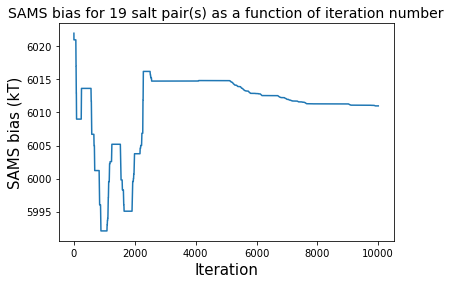

In [25]:
n = 19
plt.plot(ncfile.groups['Sample state data']['sams bias'][:,n])
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('SAMS bias (kT)', fontsize=15)
plt.title('SAMS bias for {0} salt pair(s) as a function of iteration number'.format(n), fontsize=14)
plt.show()

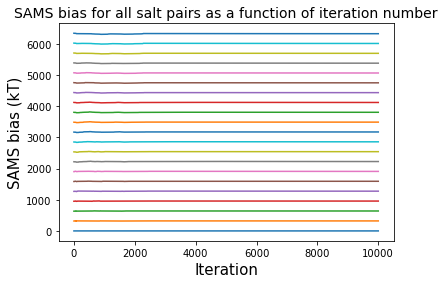

In [23]:
plt.plot(ncfile.groups['Sample state data']['sams bias'][:,:])
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('SAMS bias (kT)', fontsize=15)
plt.title('SAMS bias for all salt pairs as a function of iteration number'.format(n), fontsize=14)
plt.show()

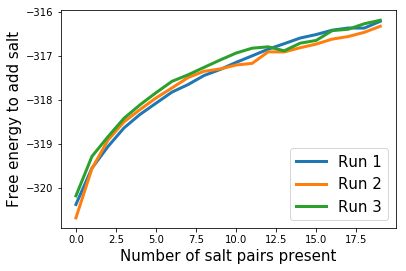

In [42]:
run = [1, 2, 3]
files = ['out1.nc','out2.nc','out3.nc']
file
for r in run:
    ncfile = Dataset('out'+str(r)+'.nc','r')
    sams_free_energies = ncfile.groups['Sample state data']['sams bias'][-1,:][1:] / np.arange(1,21)
    plt.plot(-sams_free_energies, label='Run {}'.format(r), lw=3)
plt.legend(fontsize=15)
plt.xlabel('Number of salt pairs present', fontsize=15)
plt.ylabel('Free energy to add salt', fontsize=15)
plt.show()

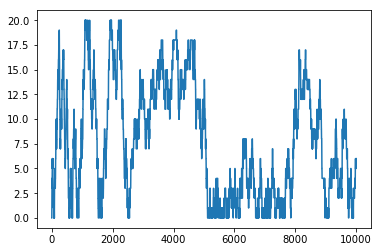

In [8]:
nsalt = ncfile.groups['Sample state data']['species counts'][:][:,1]
plt.plot(nsalt)
plt.show()

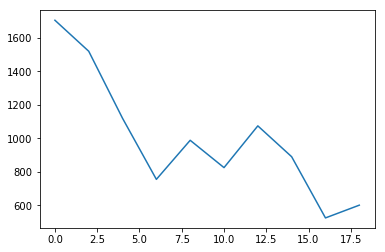

In [9]:
counts, edges = np.histogram(nsalt)
plt.plot(edges[0:-1], counts)
plt.show()

In [19]:
cumulative_work = ncfile.groups['Sample state data']['cumulative work'][:]
protocol_work = cumulative_work[:,0,-1]

In [20]:
pot_nrg = ncfile.groups['Sample state data']['potential energy'][:]
volume = ncfile.groups['Sample state data']['volume'][:]
logP = ncfile.groups['Sample state data']['log_accept'][:]
sams_bias = ncfile.groups['Sample state data']['sams bias'][:]
proposals = ncfile.groups['Sample state data']['proposal'][:][:,0,:]
nwats = ncfile.groups['Sample state data']['species counts'][:,0]
nsalt = ncfile.groups['Sample state data']['species counts'][:,1]

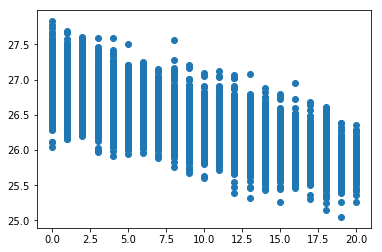

In [21]:
plt.scatter(nsalt,volume)
plt.show()

## Estimating free energy from acceptance probability

In [22]:
calc_free_energy_from_logp(19, 20, proposals, logP, sams_bias, nwats)

(-314.7970973897676, 0.35001125498774854)

In [32]:
cumulative_work[:,:,-1]

array([[-300.67675781],
       [-302.6244812 ],
       [-308.00030518],
       ..., 
       [ 311.42724609],
       [ 314.52249146],
       [-302.8717041 ]], dtype=float32)

In [41]:
calc_bar(19,20, nwats=nwats, proposals=proposals, work=cumulative_work[:,:,-1] )

(-305.25692265809738, 0.068727326518889451)

In [23]:
saltmax = 20
error = np.zeros(saltmax)
free = np.zeros(saltmax)
for i in range(saltmax):
    f, e = calc_free_energy_from_logp(i, i + 1, proposals, logP, sams_bias, nwats)
    free[i] = f
    error[i] = e

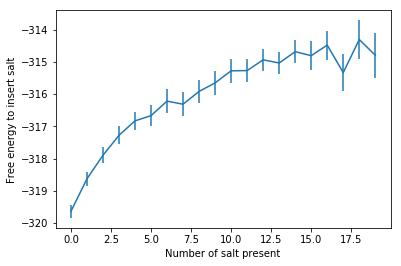

In [24]:
plt.errorbar(range(saltmax),free, yerr=error*2)
plt.xlabel('Number of salt present')
plt.ylabel('Free energy to insert salt')
plt.show()

In [16]:
# Empirical results from a box of 30 Angs length
mean_salt = np.array([  1.41388081e+01,   3.27501800e+00,   7.76315789e-01,
         9.65166909e-02,   1.44404332e-03,   7.84313725e-04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])
dmu = np.array([ 315. ,  317.5,  320. ,  322.5,  325. ,  327.5,  330. ,  332.5,
        335. ,  337.5,  340. ,  342.5,  345. ])

In [17]:
# The cumulative free energy
g = np.hstack((0.0,np.cumsum(free)))

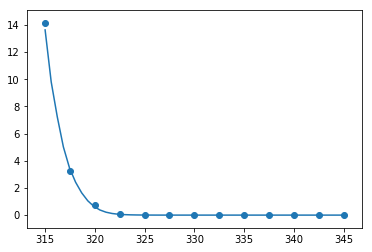

In [18]:
deltachems = np.linspace(315,345)
aven = np.zeros(len(deltachems))
for i in range(len(deltachems)):
    aven[i] = average_nsalt(-deltachems[i],saltmax=20,f=-g)
    
plt.plot(deltachems,aven)
plt.scatter(dmu,mean_salt)
plt.show()

## THIS LOOKS JUST LIKE MY TITRATION SIMULATION!

## Estimating free energy from work

In [86]:
calc_free_energy(3, 2, proposals, protocol_work)

77 66


(306.49118321677724, 0.27969790348148876)

In [114]:
saltmax = 20
error = np.zeros(saltmax)
free = np.zeros(saltmax)
for i in range(saltmax):
    f, e = calc_free_energy(i, i+1, proposals, protocol_work)
    free[i] = f
    error[i] = e

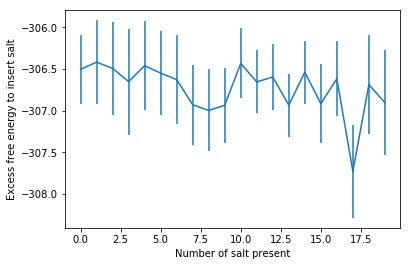

In [116]:
plt.errorbar(range(saltmax),free, yerr=error*2)
plt.xlabel('Number of salt present')
plt.ylabel('Excess free energy to insert salt')
plt.show()

## Run 2

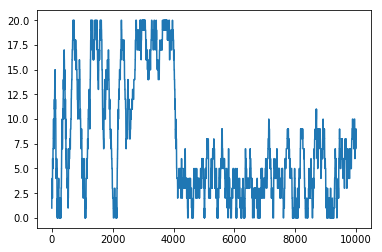

In [26]:
ncfile = Dataset('out2.nc','r')
nsalt = ncfile.groups['Sample state data']['species counts'][:][:,1]
plt.plot(nsalt)
plt.show()

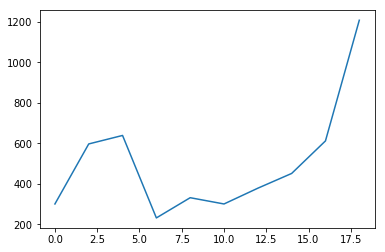

In [7]:
counts, edges = np.histogram(nsalt)
plt.plot(edges[0:-1], counts)
plt.show()

## Run 3

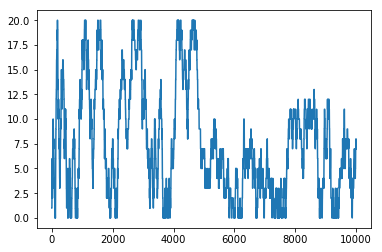

In [25]:
ncfile = Dataset('out3.nc','r')
plt.plot(ncfile.groups['Sample state data']['species counts'][:][:,1])
plt.show()

In [9]:
ncfile.groups['Sample state data']['proposal'][:]

array([[[0, 1]],

       [[1, 0]],

       [[1, 0]],

       ..., 
       [[0, 1]],

       [[0, 1]],

       [[0, 1]]], dtype=int32)

In [11]:
ncfile.groups['Sample state data']['naccepted'][:]

array([[  1],
       [  1],
       [  1],
       ..., 
       [736],
       [736],
       [736]], dtype=int32)

In [14]:
ncfile.groups['Sample state data']['naccepted'][:][-1]/ncfile.groups['Sample state data']['nattempted'][:][-1]

array([ 0.20098307])